In [1]:
from os import chdir
chdir('..')

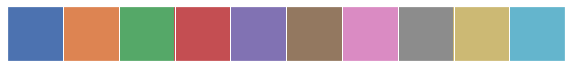

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib
import math
import seaborn as sns
import pandas as pd
import numpy as np
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString, asPolygon
from shapely.affinity import scale, translate
from os import path
from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly, load_polygon, get_max_bounds_polys, measure_convexity_simple
%matplotlib inline
sns.set(font_scale=1)  # crazy big
# sns.set_style("white")
current_palette = sns.color_palette()
sns.palplot(current_palette)

## Subtimings

These are the timings for all concave hull extraction algorithms which have a triangulation step. I'm only shwowing these algorithms together because its (somewhat) easier to compare or relate substeps of the algorihtms. Though they do not line up perfectly.

### CGAL


**Triangulation** - Uses CGAL Delaunay Triangulation. Uses CGAL methods for robust geometric predicates.

**Shape Creation** - Filters triangle faces, edges, and vertices by the alpha radius. It also classifies each of these objects. Datastructures to find the triangles, edges, and vertices of the alpha shape are created. 

**Polygon Extraction** - None. The final output of CGAL Alpha shapes is simply an the unordered list of edges of the alpha shapes. It is possible to turn this into a polgygon but no implementation that I know of is provided by CGAL. Such an implementation will also need to handle the creation of mulitpolygon output as well as holes inside individual polygons as perfomed by both Polylidar and Spatialite.

### Polylidar 


**Triangulation** - Uses Delaunator for triangulation. Uses adaptive floating point arithmetic for robust geometric predicates from https://www.cs.cmu.edu/~quake/robust.html.

**Shape Extraction** - Filters triangles by alpha radius. Executes region growing which creates disparate sets of spatially connected triangles. Each set is called a region (called planes in 3D). 

**Polygon Extraction** - For each region, the polygonal representaton is extracted. This occurs by identifying boundary edges, choosing a starting edge on the hull,, carefully walking the hull (handle edge cases when hole edges and border edges share vertices), and finally forming a linear ring representing the exterior hull. Interior holes are also extracted (once again, carefully handling edge cases).

### Spatialite

**Triangulation** - Uses GEOS to perform triangulation. Uses robust geometric predicated built into GEOS.

**Shape Extraction** - Compute edge length statistics of all triangle edges, prudcing a $\mu_l$ and $\sigma_l$. Filters any triangle who has an edge $l > \mu_l + factor \cdot \sigma_l$ 

**Polygon Extraction** - Uses GEOS to compute the union of all triangles to generate the polygonal representation of the the all remaining triangles.  

In [3]:
timings_cgal = [[46.862,160.001],[44.394,158.039],[44.468,152.339],[44.405,152.891],[44.374,152.626],[44.388,154.035],[44.466,153.964],[44.466,153.671],[44.389,153.933],[44.36,152.299],[44.444,153.398],[44.37,153.527],[44.357,153.021],[44.384,154.086],[44.462,153.508],[44.59,153.483],[44.444,153.228],[44.539,154.614],[44.462,152.466],[44.363,153.76],[44.449,154.291],[44.472,154.772],[44.573,152.665],[44.726,154.413],[44.477,154.577],[44.494,155.103],[44.508,155.043],[44.474,153.003],[44.53,153.702],[44.4,154.183]]
timings_polylidar = [[36.12799835205078, 4.36299991607666, 0.9810000061988831], [35.928001403808594, 4.394000053405762, 1.027999997138977], [36.665000915527344, 4.3470001220703125, 1.059000015258789], [35.79399871826172, 4.316999912261963, 0.9760000109672546], [35.8390007019043, 4.35699987411499, 1.1080000400543213], [36.36899948120117, 4.396999835968018, 0.9990000128746033], [35.97100067138672, 4.35699987411499, 0.9700000286102295], [35.84700012207031, 4.359000205993652, 0.9929999709129333], [35.72999954223633, 4.355000019073486, 0.9779999852180481], [35.779998779296875, 4.335999965667725, 0.9580000042915344], [36.327999114990234, 4.354000091552734, 0.9649999737739563], [35.77000045776367, 4.429999828338623, 0.9819999933242798], [36.29100036621094, 4.381999969482422, 0.972000002861023], [36.444000244140625, 4.3470001220703125, 0.9639999866485596], [35.87900161743164, 4.372000217437744, 0.9879999756813049], [35.93000030517578, 4.382999897003174, 0.9760000109672546], [35.95600128173828, 4.414999961853027, 0.9729999899864197], [36.525001525878906, 4.375999927520752, 0.9789999723434448], [35.819000244140625, 4.373000144958496, 0.9829999804496765], [36.13800048828125, 4.375999927520752, 0.9769999980926514], [36.43600082397461, 4.366000175476074, 0.9679999947547913], [35.79999923706055, 4.392000198364258, 0.9700000286102295], [35.6879997253418, 4.366000175476074, 0.9860000014305115], [35.70100021362305, 4.372000217437744, 0.9879999756813049], [36.05099868774414, 4.34499979019165, 0.9679999947547913], [35.75400161743164, 4.3379998207092285, 0.972000002861023], [36.01100158691406, 4.3470001220703125, 0.9679999947547913], [35.724998474121094, 4.35099983215332, 0.9810000061988831], [36.13600158691406, 4.339000225067139, 0.9700000286102295], [36.02899932861328, 4.368000030517578, 0.9879999756813049]]

In [18]:
df_cgal = pd.DataFrame(timings_cgal, columns=['triangulation', 'shape extraction'])
df_cgal['polygon extraction'] =  np.nan
df_cgal['algorithm'] = 'cgal'

df_pl = pd.DataFrame(timings_polylidar, columns=['triangulation', 'shape extraction', 'polygon extraction'])
df_pl['algorithm'] = 'polylidar'

df = pd.concat([df_pl, df_cgal], axis=0)

df_melt = pd.melt(df,
               id_vars=['algorithm'], value_vars=['triangulation', 'shape extraction', 'polygon extraction'],
               value_name='time')
df_melt

,algorithm,variable,time
0,polylidar,triangulation,36.127998
1,polylidar,triangulation,35.928001
2,polylidar,triangulation,36.665001
3,polylidar,triangulation,35.793999
4,polylidar,triangulation,35.839001
...,...,...,...
175,cgal,polygon extraction,NaN
176,cgal,polygon extraction,NaN
177,cgal,polygon extraction,NaN
178,cgal,polygon extraction,NaN


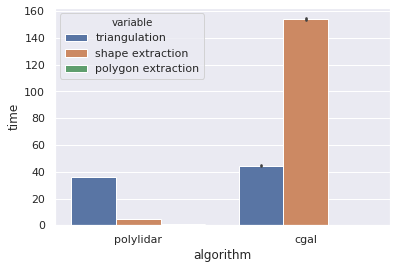

In [31]:
ax = sns.barplot(x="algorithm", y="time",
            hue="variable", data=df_melt)
# ax.set(yscale="log")